# 01 - Data Exploration and Analysis

This notebook provides comprehensive exploratory data analysis of the NASA CMAPSS turbofan engine dataset.

## Objectives
- Load and validate NASA CMAPSS dataset
- Analyze sensor correlation patterns
- Visualize engine degradation trajectories
- Identify key sensors for health monitoring
- Prepare data for feature engineering


In [17]:
# Import required libraries
import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path

# Import custom modules
from data.data_loader import CMAPSSLoader
from data.feature_engineer import FeatureEngineer

# Set plotting style
plt.style.use('seaborn')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


## 1. Load Configuration and Data


In [18]:
# Load configuration
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

print("Configuration loaded:")
print(f"- Markov states: {config['model']['markov_states']}")
print(f"- Health threshold: {config['model']['health_threshold']}")
print(f"- Primary indicators: {config['sensors']['primary_indicators']}")


Configuration loaded:
- Markov states: 4
- Health threshold: 0.8
- Primary indicators: [2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, 21]


In [19]:
# Initialize data loader
import os

# Try multiple possible paths for the data directory
possible_paths = [
    '../data/raw/',  # Relative to notebooks directory (most likely)
    'data/raw/',     # Relative to project root
    os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw'),  # Absolute path
    '/Users/brandonlewis/Desktop/pyprojects/data_science/portfolio_projects/Markov_Based_Predictive_Maintenance/data/raw/'  # Full absolute path
]

data_path = None
for path in possible_paths:
    if os.path.exists(path):
        data_path = path
        break

if data_path is None:
    print("ERROR: Could not find data directory!")
    print("Tried paths:")
    for path in possible_paths:
        print(f"  {path}: {'✓' if os.path.exists(path) else '✗'}")
    raise FileNotFoundError("Data directory not found")

print("Loading NASA CMAPSS FD001 dataset...")
print(f"Current working directory: {os.getcwd()}")
print(f"Using data path: {data_path}")

# Check if files exist
files_to_check = ['train_FD001.txt', 'test_FD001.txt', 'RUL_FD001.txt']
all_files_exist = True
for file in files_to_check:
    filepath = os.path.join(data_path, file)
    exists = os.path.exists(filepath)
    print(f"  {file}: {'✓' if exists else '✗'}")
    if not exists:
        all_files_exist = False

if not all_files_exist:
    raise FileNotFoundError("Some required data files are missing!")

# Initialize loader and load the data
loader = CMAPSSLoader(data_path)
train_data = loader.load_train_data('FD001')
test_data = loader.load_test_data('FD001')
rul_labels = loader.load_rul_labels('FD001')

print(f"\n✅ Successfully loaded all data!")
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"RUL labels shape: {rul_labels.shape}")


Loading NASA CMAPSS FD001 dataset...
Current working directory: /Users/brandonlewis/Desktop/pyprojects/data_science/portfolio_projects/Markov_Based_Predictive_Maintenance/notebooks
Using data path: ../data/raw/
  train_FD001.txt: ✓
  test_FD001.txt: ✓
  RUL_FD001.txt: ✓

✅ Successfully loaded all data!
Training data shape: (20631, 26)
Test data shape: (13096, 26)
RUL labels shape: (100, 2)


## 2. Data Validation and Basic Statistics


In [20]:
# Validate data integrity
print("Validating training data...")
train_valid = loader.validate_data_integrity(train_data)

print("\nValidating test data...")
test_valid = loader.validate_data_integrity(test_data)

print(f"\nTraining data valid: {train_valid}")
print(f"Test data valid: {test_valid}")

# Get dataset information
train_info = loader.get_dataset_info(train_data)
test_info = loader.get_dataset_info(test_data)

print("\nTraining Dataset Information:")
for key, value in train_info.items():
    print(f"  {key}: {value}")

print("\nTest Dataset Information:")
for key, value in test_info.items():
    print(f"  {key}: {value}")


Validating training data...
Data validation passed successfully

Validating test data...
Data validation passed successfully

Training data valid: True
Test data valid: True

Training Dataset Information:
  total_engines: 100
  total_cycles: 20631
  avg_cycles_per_engine: 206.31
  min_cycles: 128
  max_cycles: 362
  sensor_columns: 21
  setting_columns: 3

Test Dataset Information:
  total_engines: 100
  total_cycles: 13096
  avg_cycles_per_engine: 130.96
  min_cycles: 31
  max_cycles: 303
  sensor_columns: 21
  setting_columns: 3


## 3. Engine Trajectory Analysis


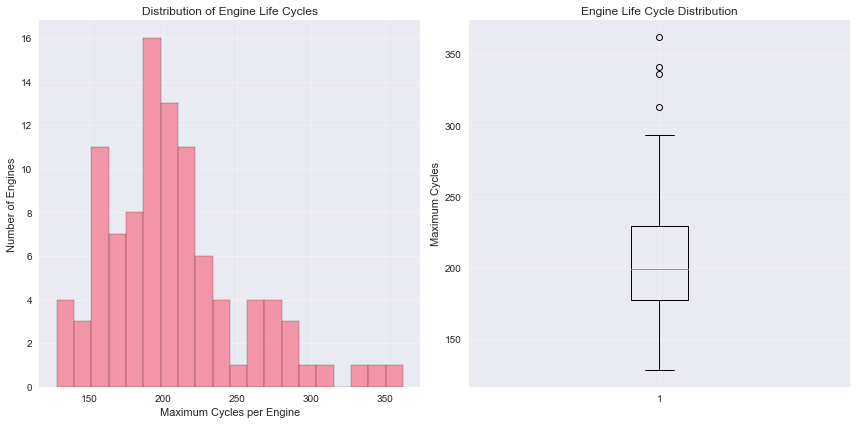

Engine cycle statistics:
  Mean: 206.3 cycles
  Median: 199.0 cycles
  Min: 128 cycles
  Max: 362 cycles
  Std: 46.3 cycles


In [21]:
# Analyze engine trajectory lengths
engine_cycles = train_data.groupby('unit')['cycle'].max()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(engine_cycles, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Maximum Cycles per Engine')
plt.ylabel('Number of Engines')
plt.title('Distribution of Engine Life Cycles')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(engine_cycles)
plt.ylabel('Maximum Cycles')
plt.title('Engine Life Cycle Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Engine cycle statistics:")
print(f"  Mean: {engine_cycles.mean():.1f} cycles")
print(f"  Median: {engine_cycles.median():.1f} cycles")
print(f"  Min: {engine_cycles.min()} cycles")
print(f"  Max: {engine_cycles.max()} cycles")
print(f"  Std: {engine_cycles.std():.1f} cycles")


## 4. Sensor Correlation Analysis


Number of sensors: 21
Sensor columns: ['sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']


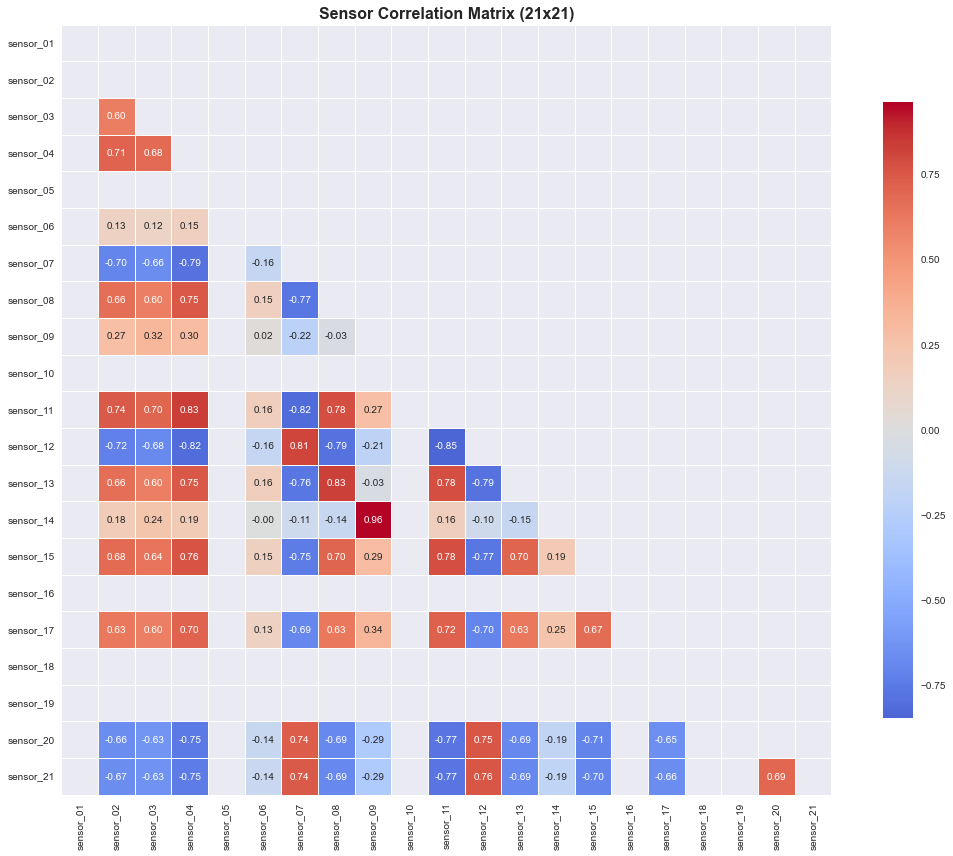

In [22]:
# Get sensor columns
sensor_columns = [col for col in train_data.columns if col.startswith('sensor_')]
print(f"Number of sensors: {len(sensor_columns)}")
print(f"Sensor columns: {sensor_columns}")

# Calculate sensor correlation matrix
sensor_data = train_data[sensor_columns]
correlation_matrix = sensor_data.corr()

# Create correlation heatmap
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Sensor Correlation Matrix (21x21)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [23]:
# Identify highly correlated sensor pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:  # High correlation threshold
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                corr_value
            ))

print(f"Highly correlated sensor pairs (|correlation| > 0.8):")
for sensor1, sensor2, corr in high_corr_pairs:
    print(f"  {sensor1} - {sensor2}: {corr:.3f}")


Highly correlated sensor pairs (|correlation| > 0.8):
  sensor_04 - sensor_11: 0.830
  sensor_04 - sensor_12: -0.816
  sensor_07 - sensor_11: -0.823
  sensor_07 - sensor_12: 0.813
  sensor_08 - sensor_13: 0.826
  sensor_09 - sensor_14: 0.963
  sensor_11 - sensor_12: -0.847


## 5. Sensor Degradation Patterns


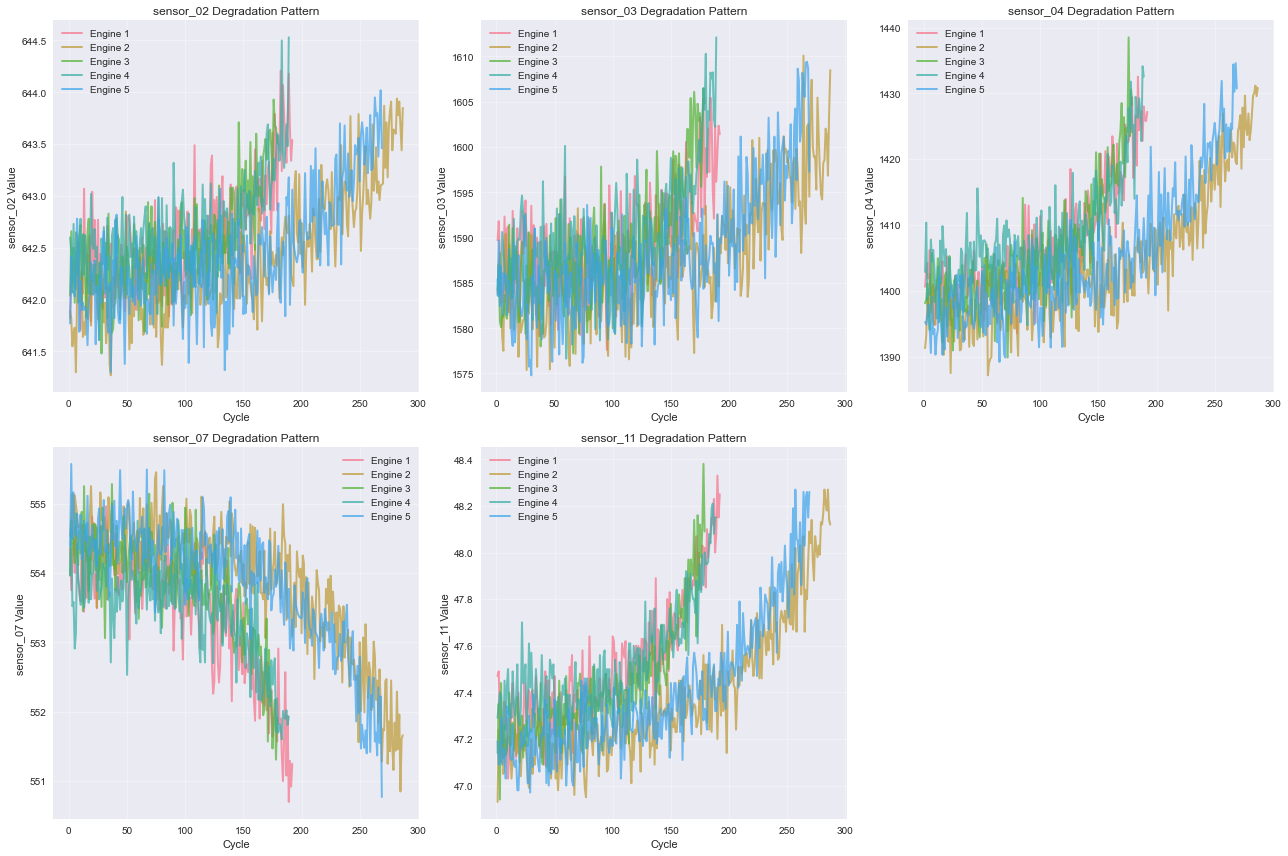

In [24]:
# Select example engines for visualization
example_engines = [1, 2, 3, 4, 5]

# Create degradation plots for key sensors
key_sensors = ['sensor_02', 'sensor_03', 'sensor_04', 'sensor_07', 'sensor_11']

# Create subplots with proper handling
n_sensors = len(key_sensors)
n_cols = 3
n_rows = (n_sensors + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))

# Handle both single row and multiple row cases
if n_rows == 1:
    axes = axes.reshape(1, -1) if n_sensors > 1 else [axes]

for i, sensor in enumerate(key_sensors):
    row = i // n_cols
    col = i % n_cols
    
    # Get the correct axis
    if n_rows == 1:
        ax = axes[0, col] if n_sensors > 1 else axes
    else:
        ax = axes[row, col]
    
    # Plot data for each engine
    for engine_id in example_engines:
        engine_data = train_data[train_data['unit'] == engine_id]
        if len(engine_data) > 0:  # Check if engine data exists
            # Convert pandas Series to numpy arrays to avoid indexing issues
            cycles = engine_data['cycle'].values
            sensor_values = engine_data[sensor].values
            ax.plot(cycles, sensor_values, 
                   label=f'Engine {engine_id}', alpha=0.7, linewidth=2)
    
    ax.set_xlabel('Cycle')
    ax.set_ylabel(f'{sensor} Value')
    ax.set_title(f'{sensor} Degradation Pattern')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove empty subplots
for i in range(n_sensors, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    if n_rows == 1:
        if n_sensors > 1:
            fig.delaxes(axes[0, col])
    else:
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


## 6. Feature Engineering Preview


In [25]:
# Initialize feature engineer
feature_engineer = FeatureEngineer(config)

# Apply feature engineering to a subset of data
sample_data = train_data[train_data['unit'] <= 5].copy()  # Use first 5 engines
print(f"Sample data shape: {sample_data.shape}")

# Apply feature engineering
engineered_data = feature_engineer.create_engineered_features(sample_data, is_training=True)
print(f"Engineered data shape: {engineered_data.shape}")

# Display feature categories
feature_categories = feature_engineer.get_feature_list(engineered_data)
print("\nFeature Categories:")
for category, features in feature_categories.items():
    print(f"  {category}: {len(features)} features")
    if len(features) <= 10:  # Show features if not too many
        print(f"    {features}")


Sample data shape: (1116, 26)
Starting feature engineering pipeline...
✓ RUL labels calculated
✓ Rolling features created
✓ Degradation indicators created
✓ Health states classified
✓ Features normalized
Feature engineering pipeline completed!
Engineered data shape: (1116, 557)

Feature Categories:
  basic: 2 features
    ['unit', 'cycle']
  settings: 3 features
    ['setting1', 'setting2', 'setting3']
  sensors: 273 features
  sensors_normalized: 273 features
  rolling: 504 features
  health_indicators: 4 features
    ['temp_health_index', 'pressure_health_index', 'flow_health_index', 'overall_health_index']
  targets: 2 features
    ['RUL', 'health_state']


## 7. Health State Distribution


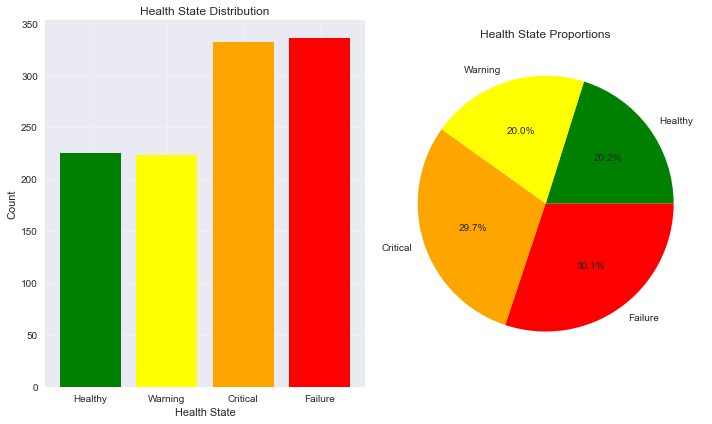

Health State Distribution:
  Healthy: 225 (20.2%)
  Critical: 332 (29.7%)
  Failure: 336 (30.1%)


In [26]:
# Analyze health state distribution
if 'health_state' in engineered_data.columns:
    health_state_counts = engineered_data['health_state'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    # Convert to numpy arrays to avoid pandas plotting issues
    states = health_state_counts.index.values
    counts = health_state_counts.values
    colors = ['green', 'yellow', 'orange', 'red']
    plt.bar(states, counts, color=colors)
    plt.xlabel('Health State')
    plt.ylabel('Count')
    plt.title('Health State Distribution')
    plt.xticks(range(4), ['Healthy', 'Warning', 'Critical', 'Failure'], rotation=0)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.pie(health_state_counts.values, labels=['Healthy', 'Warning', 'Critical', 'Failure'], 
            autopct='%1.1f%%', colors=['green', 'yellow', 'orange', 'red'])
    plt.title('Health State Proportions')
    
    plt.tight_layout()
    plt.show()
    
    print("Health State Distribution:")
    for state, count in health_state_counts.items():
        state_name = ['Healthy', 'Warning', 'Critical', 'Failure'][state]
        percentage = (count / len(engineered_data)) * 100
        print(f"  {state_name}: {count} ({percentage:.1f}%)")


## 8. Summary and Next Steps


In [27]:
print("=== DATA EXPLORATION SUMMARY ===")
print(f"\nDataset Overview:")
print(f"  - Training engines: {train_info['total_engines']}")
print(f"  - Average cycles per engine: {train_info['avg_cycles_per_engine']:.1f}")
print(f"  - Total training cycles: {train_info['total_cycles']}")
print(f"  - Number of sensors: {train_info['sensor_columns']}")

print(f"\nKey Findings:")
print(f"  - Engine life varies significantly: {engine_cycles.min()}-{engine_cycles.max()} cycles")
print(f"  - High correlation pairs: {len(high_corr_pairs)}")
print(f"  - Primary indicators configured: {len(config['sensors']['primary_indicators'])}")

print(f"\nNext Steps:")
print(f"  1. Complete feature engineering pipeline")
print(f"  2. Implement Markov Chain model")
print(f"  3. Develop Hidden Markov Model")
print(f"  4. Train baseline models for comparison")
print(f"  5. Evaluate model performance")


=== DATA EXPLORATION SUMMARY ===

Dataset Overview:
  - Training engines: 100
  - Average cycles per engine: 206.3
  - Total training cycles: 20631
  - Number of sensors: 21

Key Findings:
  - Engine life varies significantly: 128-362 cycles
  - High correlation pairs: 7
  - Primary indicators configured: 14

Next Steps:
  1. Complete feature engineering pipeline
  2. Implement Markov Chain model
  3. Develop Hidden Markov Model
  4. Train baseline models for comparison
  5. Evaluate model performance
